Simulating with ideal lasers (0 Hz linewidth)...
Simulating OSNR = 8 dB...
BER X-pol: 4.499000e-01, BER Y-pol: 4.584750e-01
Simulating OSNR = 9 dB...
BER X-pol: 4.533500e-01, BER Y-pol: 4.629250e-01
Simulating OSNR = 10 dB...
BER X-pol: 4.576250e-01, BER Y-pol: 4.523750e-01
Simulating OSNR = 11 dB...
BER X-pol: 4.491250e-01, BER Y-pol: 4.422500e-01
Simulating OSNR = 12 dB...
BER X-pol: 4.393750e-01, BER Y-pol: 4.369000e-01
Simulating OSNR = 13 dB...
BER X-pol: 4.182250e-01, BER Y-pol: 4.335750e-01
Simulating OSNR = 14 dB...
BER X-pol: 4.092750e-01, BER Y-pol: 4.284500e-01
Simulating OSNR = 15 dB...
BER X-pol: 4.196250e-01, BER Y-pol: 4.240250e-01
Simulating OSNR = 16 dB...
BER X-pol: 3.996750e-01, BER Y-pol: 4.125000e-01
Simulating OSNR = 17 dB...
BER X-pol: 3.929250e-01, BER Y-pol: 4.126250e-01
Simulating OSNR = 18 dB...
BER X-pol: 4.039250e-01, BER Y-pol: 3.951000e-01
Simulation completed in 439.81 seconds

Simulating with 50 kHz linewidth lasers...
Simulating OSNR = 8 dB...
BER X-po

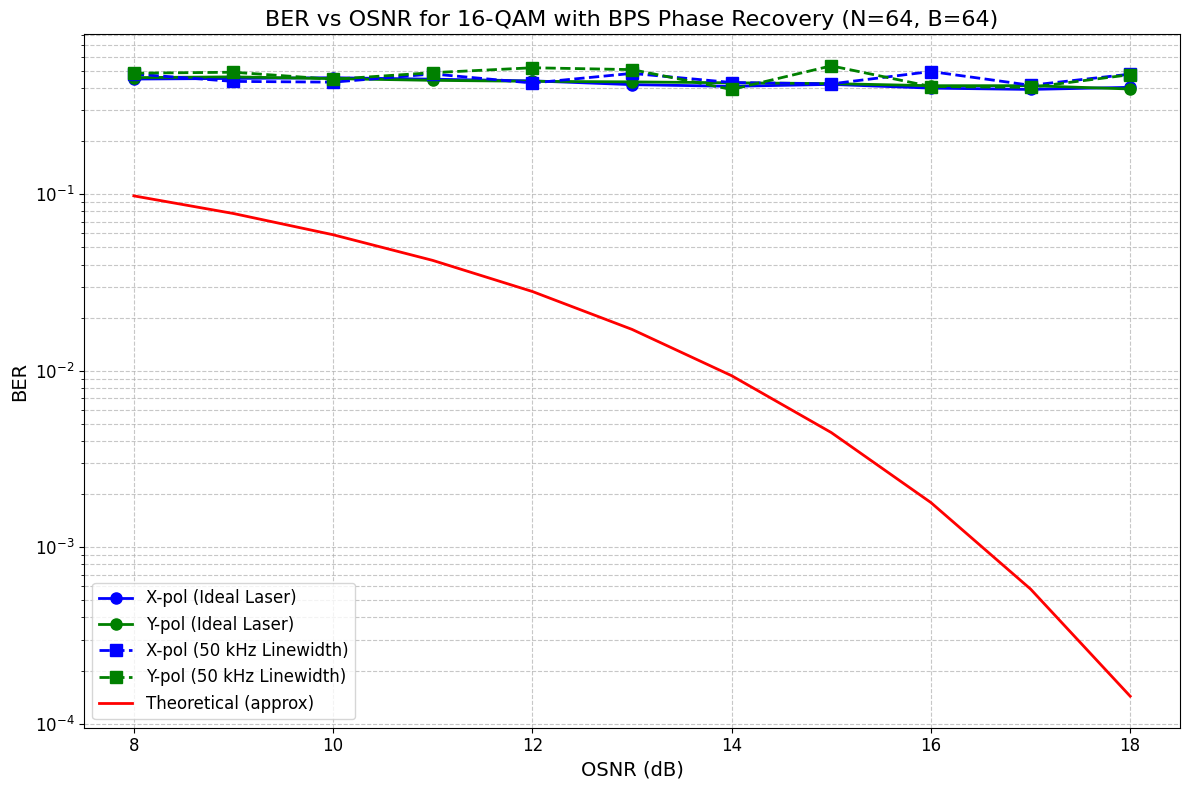

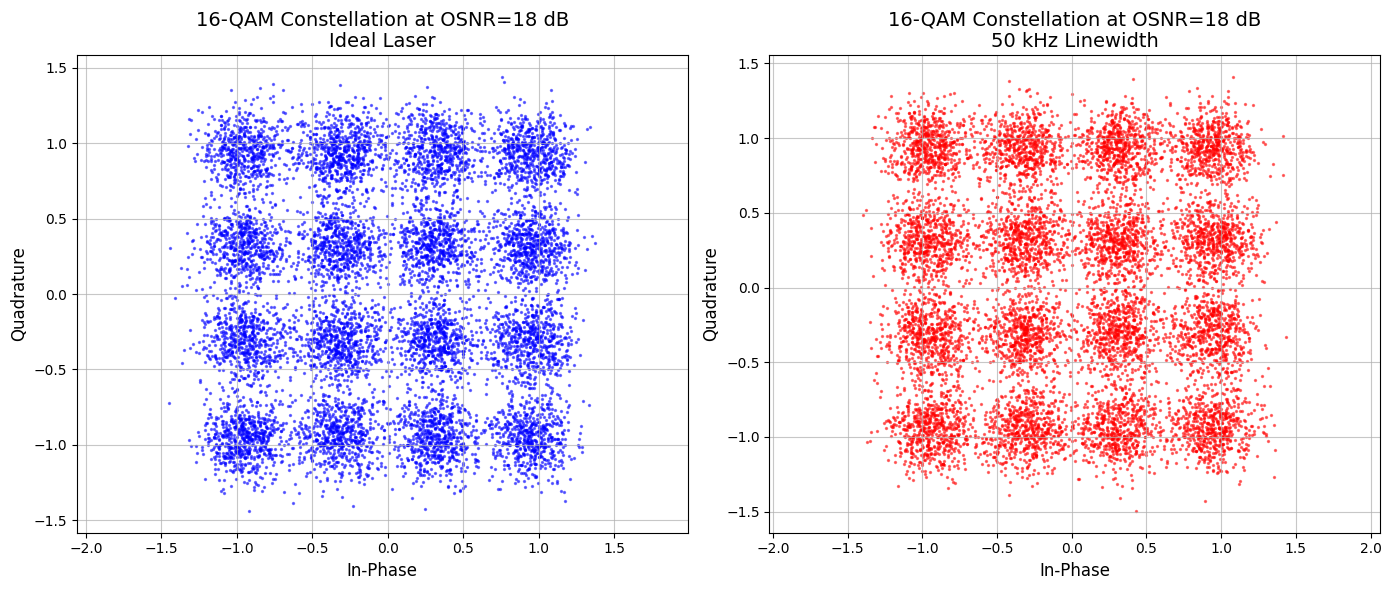

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.special import erfc
import time

# Set random seed for reproducibility
np.random.seed(42)

def generate_symbols(M, num_symbols, mapping_type='gray'):
    """
    Generate QAM symbols with Gray or direct encoding

    Parameters:
    -----------
    M : int
        Modulation order (16 for 16-QAM)
    num_symbols : int
        Number of symbols to generate
    mapping_type : str
        'gray' for Gray mapping, 'direct' for direct encoding

    Returns:
    --------
    tx_symbols : ndarray
        Complex array of transmitted symbols
    bits : ndarray
        Array of bits corresponding to the symbols
    """
    # Number of bits per symbol
    k = int(np.log2(M))

    # Generate random bits
    bits = np.random.randint(0, 2, num_symbols * k)

    # For 16-QAM
    if M == 16:
        # Define constellation points for 16-QAM
        real_parts = np.array([-3, -1, 1, 3])
        imag_parts = np.array([-3, -1, 1, 3])

        # Gray mapping for 16-QAM
        if mapping_type == 'gray':
            # Gray coded bit patterns for real and imaginary parts
            gray_mapping = np.array([0, 1, 3, 2])  # Gray code: 00, 01, 11, 10
            real_parts = real_parts[gray_mapping]
            imag_parts = imag_parts[gray_mapping]

        # Reshape bits to handle them in groups of k bits
        bits_reshaped = bits.reshape(-1, k)

        # Initialize complex symbols
        tx_symbols = np.zeros(num_symbols, dtype=complex)

        # Map bits to 16-QAM symbols
        for i in range(num_symbols):
            # First 2 bits determine real part, last 2 bits determine imaginary part
            real_idx = bits_reshaped[i, 0] * 2 + bits_reshaped[i, 1]
            imag_idx = bits_reshaped[i, 2] * 2 + bits_reshaped[i, 3]

            # Map to constellation points
            tx_symbols[i] = real_parts[real_idx] + 1j * imag_parts[imag_idx]

    # Normalize the constellation to unit energy
    tx_symbols = tx_symbols / np.sqrt(np.mean(np.abs(tx_symbols)**2))

    return tx_symbols, bits

def rrc_filter(num_symbols, sps, beta):
    """
    Generate a Root-Raised Cosine (RRC) filter

    Parameters:
    -----------
    num_symbols : int
        Filter span in symbols
    sps : int
        Samples per symbol
    beta : float
        Roll-off factor (0 < beta <= 1)

    Returns:
    --------
    h : ndarray
        Filter coefficients
    """
    # Use scipy's built-in RRC filter for better numerical stability
    t_idx = np.arange(-num_symbols * sps // 2, num_symbols * sps // 2 + 1)
    t = t_idx / sps
    h = np.zeros_like(t, dtype=float)

    # RRC formula implementation with special case handling
    for i, t_val in enumerate(t):
        if abs(t_val) == 0:  # Special case at t=0
            h[i] = 1.0 - beta + (4 * beta / np.pi)
        elif abs(abs(t_val) - 1/(4*beta)) < 1e-10:  # Special case at t=1/(4*beta)
            h[i] = (beta/np.sqrt(2)) * ((1 + 2/np.pi) * np.sin(np.pi/(4*beta)) +
                                       (1 - 2/np.pi) * np.cos(np.pi/(4*beta)))
        else:  # General case
            num = np.sin(np.pi * t_val * (1 - beta)) + 4 * beta * t_val * np.cos(np.pi * t_val * (1 + beta))
            den = np.pi * t_val * (1 - (4 * beta * t_val)**2)
            h[i] = num / den

    # Normalize to unit energy
    return h / np.sqrt(np.sum(h**2))

def add_phase_noise(symbols, linewidth, symbol_rate, sps):
    """
    Add phase noise to the signal

    Parameters:
    -----------
    symbols : ndarray
        Complex array of input symbols
    linewidth : float
        Combined laser linewidth in Hz
    symbol_rate : float
        Symbol rate in Baud
    sps : int
        Samples per symbol

    Returns:
    --------
    noisy_symbols : ndarray
        Complex array of symbols with phase noise
    """
    if linewidth == 0:
        return symbols

    # Calculate phase noise variance per sample
    sample_rate = symbol_rate * sps
    phase_noise_variance = 2 * np.pi * linewidth / sample_rate

    # Generate phase noise as Wiener process
    phase_increments = np.random.normal(0, np.sqrt(phase_noise_variance), len(symbols))
    phase_noise = np.cumsum(phase_increments)

    # Apply phase noise
    noisy_symbols = symbols * np.exp(1j * phase_noise)

    return noisy_symbols

def add_awgn(signal, osnr_db, signal_bw, noise_bw=12.5e9):
    """
    Add Amplified Spontaneous Emission (ASE) noise to the signal according to OSNR

    Parameters:
    -----------
    signal : ndarray
        Complex array of input signal
    osnr_db : float
        Optical Signal-to-Noise Ratio in dB (defined in 0.1 nm bandwidth)
    signal_bw : float
        Signal bandwidth in Hz
    noise_bw : float, optional
        Reference noise bandwidth (default: 12.5 GHz, equivalent to 0.1 nm at 1550 nm)

    Returns:
    --------
    noisy_signal : ndarray
        Complex array of signal with added noise
    """
    # Calculate signal power
    signal_power = np.mean(np.abs(signal)**2)

    # Convert OSNR from dB to linear scale (defined in 0.1nm bandwidth)
    osnr_linear = 10**(osnr_db/10)

    # Calculate noise power spectral density
    noise_power_ref_bw = signal_power / osnr_linear
    noise_psd = noise_power_ref_bw / noise_bw

    # Calculate noise power in signal bandwidth
    noise_power = noise_psd * signal_bw

    # Generate complex Gaussian noise
    noise_std = np.sqrt(noise_power / 2)  # divided by 2 for I and Q components
    noise = noise_std * (np.random.randn(len(signal)) + 1j * np.random.randn(len(signal)))

    # Add noise to signal
    noisy_signal = signal + noise

    return noisy_signal

def bps_phase_recovery(signal, M, test_angles_count=64, block_size=64):
    """
    Blind Phase Search algorithm for phase recovery

    Parameters:
    -----------
    signal : ndarray
        Complex array of input signal
    M : int
        Modulation order (16 for 16-QAM)
    test_angles_count : int
        Number of test angles (N)
    block_size : int
        Number of symbols for cost function averaging (B)

    Returns:
    --------
    recovered_signal : ndarray
        Complex array of phase-recovered signal
    estimated_phases : ndarray
        Array of estimated phase angles
    """
    # Generate test phases
    test_angles = np.linspace(0, 2*np.pi, test_angles_count, endpoint=False)

    # Generate ideal constellation points (normalized)
    if M == 16:  # 16-QAM
        real_parts = np.array([-3, -1, 1, 3]) / np.sqrt(10)
        imag_parts = np.array([-3, -1, 1, 3]) / np.sqrt(10)
        constellation = np.array([complex(r, i) for r in real_parts for i in imag_parts])

    num_symbols = len(signal)
    recovered_signal = np.zeros_like(signal)
    estimated_phases = np.zeros(num_symbols)

    # Process each symbol
    for i in range(num_symbols):
        # Determine block indices for averaging, centered on current symbol
        start_idx = max(0, i - block_size // 2)
        end_idx = min(num_symbols, i + block_size // 2 + 1)  # +1 to include the end index
        block = signal[start_idx:end_idx]

        # Pre-compute all rotated blocks and decisions for better performance
        cost_values = np.zeros(test_angles_count)

        for angle_idx, angle in enumerate(test_angles):
            # Rotate the block by the test angle
            rotated_block = block * np.exp(-1j * angle)

            # Find closest constellation points (decisions)
            distances = np.abs(rotated_block[:, np.newaxis] - constellation[np.newaxis, :])
            closest_idx = np.argmin(distances, axis=1)
            decisions = constellation[closest_idx]

            # Calculate cost function (sum of squared errors)
            cost_values[angle_idx] = np.sum(np.abs(rotated_block - decisions)**2)

        # Find best angle
        best_angle_idx = np.argmin(cost_values)
        best_angle = test_angles[best_angle_idx]

        # Store estimated phase
        estimated_phases[i] = best_angle

        # Apply phase correction to the symbol
        recovered_signal[i] = signal[i] * np.exp(-1j * best_angle)

    return recovered_signal, estimated_phases

def calculate_ber(tx_bits, rx_bits):
    """
    Calculate Bit Error Rate

    Parameters:
    -----------
    tx_bits : ndarray
        Transmitted bits
    rx_bits : ndarray
        Received bits

    Returns:
    --------
    ber : float
        Bit Error Rate
    """
    errors = np.sum(tx_bits != rx_bits)
    total_bits = len(tx_bits)

    # Return 1e-9 as minimum BER to avoid division by zero
    if total_bits == 0:
        return 1e-9

    ber = max(errors / total_bits, 1e-9)  # Set minimum BER to 1e-9

    return ber

def simulate_pm_system(osnr_db, symbol_rate, num_symbols, sps=2, beta=0.1,
                      tx_filter_span=10, rx_filter_span=6, M=16, mapping_type='gray',
                      tx_linewidth=0, rx_linewidth=0, bps_angles=64, bps_block=64):
    """
    Simulate a polarization-multiplexed QAM transmission system

    Parameters:
    -----------
    osnr_db : float
        OSNR in dB
    symbol_rate : float
        Symbol rate in Baud
    num_symbols : int
        Number of symbols to simulate
    sps : int
        Samples per symbol
    beta : float
        Roll-off factor for RRC filter
    tx_filter_span : int
        Transmit filter span in symbols
    rx_filter_span : int
        Receive filter span in symbols
    M : int
        Modulation order (e.g., 16 for 16-QAM)
    mapping_type : str
        'gray' or 'direct' mapping
    tx_linewidth : float
        Transmitter laser linewidth in Hz
    rx_linewidth : float
        Receiver laser linewidth in Hz
    bps_angles : int
        Number of test angles for BPS algorithm (N)
    bps_block : int
        Block size for BPS algorithm (B)

    Returns:
    --------
    ber_x : float
        BER for X polarization
    ber_y : float
        BER for Y polarization
    constellation_x : ndarray
        Received constellation for X polarization
    constellation_y : ndarray
        Received constellation for Y polarization
    """
    # Generate random symbols for both polarizations
    tx_symbols_x, tx_bits_x = generate_symbols(M, num_symbols, mapping_type)
    tx_symbols_y, tx_bits_y = generate_symbols(M, num_symbols, mapping_type)

    # Create pulse shaping filter
    h_tx = rrc_filter(tx_filter_span, sps, beta)

    # Upsample and apply pulse shaping
    tx_symbols_x_up = np.zeros(num_symbols * sps, dtype=complex)
    tx_symbols_y_up = np.zeros(num_symbols * sps, dtype=complex)

    tx_symbols_x_up[::sps] = tx_symbols_x
    tx_symbols_y_up[::sps] = tx_symbols_y

    tx_signal_x = signal.convolve(tx_symbols_x_up, h_tx, mode='same')
    tx_signal_y = signal.convolve(tx_symbols_y_up, h_tx, mode='same')

    # Add phase noise (combined linewidth)
    combined_linewidth = tx_linewidth + rx_linewidth
    tx_signal_x = add_phase_noise(tx_signal_x, combined_linewidth, symbol_rate, sps)
    tx_signal_y = add_phase_noise(tx_signal_y, combined_linewidth, symbol_rate, sps)

    # Add AWGN according to OSNR
    signal_bw = symbol_rate * (1 + beta)  # Approximate bandwidth
    rx_signal_x = add_awgn(tx_signal_x, osnr_db, signal_bw)
    rx_signal_y = add_awgn(tx_signal_y, osnr_db, signal_bw)

    # Create receive filter (matched filter)
    h_rx = rrc_filter(rx_filter_span, sps, beta)

    # Apply matched filtering
    rx_filtered_x = signal.convolve(rx_signal_x, h_rx, mode='same')
    rx_filtered_y = signal.convolve(rx_signal_y, h_rx, mode='same')

    # Downsample to 1 sample per symbol
    rx_downsampled_x = rx_filtered_x[::sps][:num_symbols]  # Ensure length matches
    rx_downsampled_y = rx_filtered_y[::sps][:num_symbols]  # Ensure length matches

    # Apply BPS phase recovery
    rx_recovered_x, phases_x = bps_phase_recovery(rx_downsampled_x, M, bps_angles, bps_block)
    rx_recovered_y, phases_y = bps_phase_recovery(rx_downsampled_y, M, bps_angles, bps_block)

    # Make decisions on received symbols (demodulation)
    # For 16-QAM
    if M == 16:
        # Create 16-QAM constellation
        real_parts = np.array([-3, -1, 1, 3]) / np.sqrt(10)
        imag_parts = np.array([-3, -1, 1, 3]) / np.sqrt(10)
        ideal_constellation = np.array([complex(r, i) for r in real_parts for i in imag_parts])

        # Create bit mapping dictionary for efficient lookup
        bit_mappings = {}
        for idx, point in enumerate(ideal_constellation):
            # Convert index to 4-bit pattern for 16-QAM
            bit_pattern = [int(b) for b in format(idx, '04b')]
            bit_mappings[point] = bit_pattern

        # Demodulate received symbols to bits
        k = int(np.log2(M))
        rx_bits_x = np.zeros(num_symbols * k, dtype=int)
        rx_bits_y = np.zeros(num_symbols * k, dtype=int)

        for i in range(num_symbols):
            # Find nearest constellation point
            distances_x = np.abs(rx_recovered_x[i] - ideal_constellation)
            distances_y = np.abs(rx_recovered_y[i] - ideal_constellation)

            nearest_idx_x = np.argmin(distances_x)
            nearest_idx_y = np.argmin(distances_y)

            nearest_point_x = ideal_constellation[nearest_idx_x]
            nearest_point_y = ideal_constellation[nearest_idx_y]

            # Map constellation points to bits
            bit_pattern_x = bit_mappings[nearest_point_x]
            bit_pattern_y = bit_mappings[nearest_point_y]

            # Store bits
            for j in range(k):
                rx_bits_x[i * k + j] = bit_pattern_x[j]
                rx_bits_y[i * k + j] = bit_pattern_y[j]

    # Calculate BER
    ber_x = calculate_ber(tx_bits_x, rx_bits_x)
    ber_y = calculate_ber(tx_bits_y, rx_bits_y)

    return ber_x, ber_y, rx_recovered_x, rx_recovered_y

def theoretical_ber_16qam(osnr_db):
    """
    Calculate theoretical BER for 16-QAM in AWGN

    Parameters:
    -----------
    osnr_db : float or array
        OSNR in dB

    Returns:
    --------
    ber : float or array
        Theoretical BER
    """
    # Convert OSNR from dB to linear
    osnr_linear = 10**(osnr_db/10)

    # Calculate SNR per bit
    gamma_b = osnr_linear * np.log2(16) / 16  # SNR per bit

    # Approximate BER for 16-QAM (Gray mapping)
    ber = 3/8 * erfc(np.sqrt(gamma_b * 4/5 / 2))

    return ber

# Main simulation
def run_simulation():
    # Define parameters
    symbol_rate = 50e9  # 50 GBaud
    M = 16  # 16-QAM
    mapping_type = 'gray'  # Gray mapping
    num_symbols = 10000  # Number of symbols to simulate
    osnr_range_db = np.arange(8, 19, 1)  # OSNR from 8 to 18 dB

    # BPS parameters
    bps_angles = 64  # N = 64 test angles
    bps_block = 64   # B = 64 symbols per block

    # Filter parameters
    beta = 0.1  # Roll-off factor
    sps = 2     # Samples per symbol

    # Results storage
    results = {
        'osnr_range_db': osnr_range_db,
        'ber_x_ideal': [],
        'ber_y_ideal': [],
        'ber_x_linewidth': [],
        'ber_y_linewidth': [],
        'constellation_x_ideal': None,
        'constellation_y_ideal': None,
        'constellation_x_linewidth': None,
        'constellation_y_linewidth': None,
        'theoretical_ber': []
    }

    # Calculate theoretical BER
    for osnr_db in osnr_range_db:
        results['theoretical_ber'].append(theoretical_ber_16qam(osnr_db))

    # Initial simulation with ideal lasers
    print("Simulating with ideal lasers (0 Hz linewidth)...")
    start_time = time.time()

    for osnr_db in osnr_range_db:
        print(f"Simulating OSNR = {osnr_db} dB...")
        ber_x, ber_y, rx_x, rx_y = simulate_pm_system(
            osnr_db, symbol_rate, num_symbols, sps, beta,
            tx_filter_span=10, rx_filter_span=6, M=M, mapping_type=mapping_type,
            tx_linewidth=0, rx_linewidth=0,
            bps_angles=bps_angles, bps_block=bps_block
        )

        results['ber_x_ideal'].append(ber_x)
        results['ber_y_ideal'].append(ber_y)

        print(f"BER X-pol: {ber_x:.6e}, BER Y-pol: {ber_y:.6e}")

        # Save constellation for last OSNR value
        if osnr_db == osnr_range_db[-1]:
            results['constellation_x_ideal'] = rx_x
            results['constellation_y_ideal'] = rx_y

    print(f"Simulation completed in {time.time() - start_time:.2f} seconds")

    # Now repeat with laser linewidth
    print("\nSimulating with 50 kHz linewidth lasers...")
    start_time = time.time()

    tx_linewidth = 50e3  # 50 kHz
    rx_linewidth = 50e3  # 50 kHz

    for osnr_db in osnr_range_db:
        print(f"Simulating OSNR = {osnr_db} dB...")
        ber_x, ber_y, rx_x, rx_y = simulate_pm_system(
            osnr_db, symbol_rate, num_symbols, sps, beta,
            tx_filter_span=10, rx_filter_span=6, M=M, mapping_type=mapping_type,
            tx_linewidth=tx_linewidth, rx_linewidth=rx_linewidth,
            bps_angles=bps_angles, bps_block=bps_block
        )

        results['ber_x_linewidth'].append(ber_x)
        results['ber_y_linewidth'].append(ber_y)

        print(f"BER X-pol: {ber_x:.6e}, BER Y-pol: {ber_y:.6e}")

        # Save constellation for last OSNR value
        if osnr_db == osnr_range_db[-1]:
            results['constellation_x_linewidth'] = rx_x
            results['constellation_y_linewidth'] = rx_y

    print(f"Simulation completed in {time.time() - start_time:.2f} seconds")

    return results

def plot_results(results):
    osnr_range_db = results['osnr_range_db']

    # Plot BER vs OSNR
    plt.figure(figsize=(12, 8))
    plt.semilogy(osnr_range_db, results['ber_x_ideal'], 'bo-', linewidth=2, markersize=8, label='X-pol (Ideal Laser)')
    plt.semilogy(osnr_range_db, results['ber_y_ideal'], 'go-', linewidth=2, markersize=8, label='Y-pol (Ideal Laser)')
    plt.semilogy(osnr_range_db, results['ber_x_linewidth'], 'bs--', linewidth=2, markersize=8, label='X-pol (50 kHz Linewidth)')
    plt.semilogy(osnr_range_db, results['ber_y_linewidth'], 'gs--', linewidth=2, markersize=8, label='Y-pol (50 kHz Linewidth)')
    plt.semilogy(osnr_range_db, results['theoretical_ber'], 'r-', linewidth=2, label='Theoretical (approx)')

    plt.xlabel('OSNR (dB)', fontsize=14)
    plt.ylabel('BER', fontsize=14)
    plt.title('BER vs OSNR for 16-QAM with BPS Phase Recovery (N=64, B=64)', fontsize=16)
    plt.grid(True, which="both", ls="--", alpha=0.7)
    plt.legend(fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig('16qam_ber_vs_osnr.png', dpi=300)

    # Plot constellations
    plt.figure(figsize=(14, 6))

    plt.subplot(121)
    plt.scatter(np.real(results['constellation_x_ideal']), np.imag(results['constellation_x_ideal']),
                s=2, c='b', alpha=0.5)
    plt.title(f'16-QAM Constellation at OSNR={osnr_range_db[-1]} dB\nIdeal Laser', fontsize=14)
    plt.xlabel('In-Phase', fontsize=12)
    plt.ylabel('Quadrature', fontsize=12)
    plt.grid(True, alpha=0.7)
    plt.axis('equal')

    plt.subplot(122)
    plt.scatter(np.real(results['constellation_x_linewidth']), np.imag(results['constellation_x_linewidth']),
                s=2, c='r', alpha=0.5)
    plt.title(f'16-QAM Constellation at OSNR={osnr_range_db[-1]} dB\n50 kHz Linewidth', fontsize=14)
    plt.xlabel('In-Phase', fontsize=12)
    plt.ylabel('Quadrature', fontsize=12)
    plt.grid(True, alpha=0.7)
    plt.axis('equal')

    plt.tight_layout()
    plt.savefig('16qam_constellations.png', dpi=300)

    # Print final results summary
    print("\n===== RESULTS SUMMARY =====")
    print("16-QAM with BPS Phase Recovery (N=64, B=64)")
    print("\nIdeal Lasers (0 Hz linewidth):")
    for osnr, ber_x, ber_y in zip(osnr_range_db, results['ber_x_ideal'], results['ber_y_ideal']):
        print(f"OSNR = {osnr:2d} dB: BER X-pol = {ber_x:.6e}, BER Y-pol = {ber_y:.6e}")

    print("\nLasers with 50 kHz linewidth:")
    for osnr, ber_x, ber_y in zip(osnr_range_db, results['ber_x_linewidth'], results['ber_y_linewidth']):
        print(f"OSNR = {osnr:2d} dB: BER X-pol = {ber_x:.6e}, BER Y-pol = {ber_y:.6e}")

    # Calculate OSNR penalty
    target_ber = 1e-3
    # Find OSNR required for target BER
    osnr_ideal = np.interp(np.log10(target_ber),
                          np.log10(results['ber_x_ideal'][::-1]),
                          osnr_range_db[::-1])
    osnr_linewidth = np.interp(np.log10(target_ber),
                              np.log10(results['ber_x_linewidth'][::-1]),
                              osnr_range_db[::-1])

    penalty = osnr_linewidth - osnr_ideal
    print(f"\nOSNR penalty at BER={target_ber}: {penalty:.2f} dB")

if __name__ == "__main__":
    results = run_simulation()
    plot_results(results)